<a href="https://colab.research.google.com/github/CodeAlamin2024/DataScience-Project/blob/main/DSA210_CRT_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SETUP**

In [16]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tests (hypothesis testing)
from scipy.stats import chi2_contingency, ttest_ind, pearsonr, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest

# Machine learning tools (for classification / prediction later)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Plotting style: keep matplotlib default but enable Seaborn theme for nicer charts
plt.style.use("default")
sns.set_theme()

# Make pandas tables easier to inspect in the notebook
pd.set_option("display.max_columns", 100) # show up to 100 columns
pd.set_option("display.width", 140) # widen the console display


I import all required Python libraries for the project (data handling, visualization, statistics, and machine learning) and set some global display options so that tables and charts are easier to read throughout the notebook.

# **LOAD DATASET**

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
DATA_PATH = "/content/drive/MyDrive/GBPUSD CRT H4 - M15 BKTST DATA.xlsx"
DATE_COL = "DATE"
SHEET_NAME = None

df_raw = pd.read_excel(DATA_PATH, sheet_name=0, header=1)
df_raw.head()


,DATE,ENTRY TIME,EXIT TIME,DURATION,PAIR,SESSION,STRATEGY,ENTRY TF,BIAS TF,ENTRY PRICE,STOP LOSS (SL),TAKE PROFIT (TP),POSITION (BUY/SELL),LOT SIZE,EXIT PRICE,PIPS GAINED / LOST,RISK-REWARD RATIO (RRR),WIN / LOSS,NOTES / MARKET CONTEXT,% RETURN
0,2025-01-03,16:15:00,14:00 (Next Day),21:45:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.24026,1.23855,1.25055,BUY,0.05,1.25055,102.9,6.02,WIN,https://www.tradingview.com/x/tT1nb6zD/,6.02
1,2025-01-03,16:45:00,14:00 (Next Day),21:15:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.23998,1.23855,1.25055,BUY,0.06,1.25055,105.8,7.35,WIN,https://www.tradingview.com/x/tT1nb6zD/,7.35
2,2025-01-10,11:00:00,16:30:00,05:30:00,GBPUSD,LONDON SESSION,CRT 4H - 15M,M15,4H,1.22846,1.22656,1.23246,BUY,0.05,1.22656,19.0,-1.00,LOSS,https://www.tradingview.com/x/lnDPWPmS/,-1.00
3,2025-01-13,16:45:00,01:30 (Next Day),08:45:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.21383,1.20983,1.22181,BUY,0.02,1.22181,79.8,2.00,WIN,https://www.tradingview.com/x/08feEYlT/,2.00
4,2025-01-14,07:00:00,12:15:00,05:15:00,GBPUSD,LONDON SESSION,CRT 4H - 15M,M15,4H,1.22075,1.21904,1.22503,BUY,0.05,1.21904,17.1,-1.00,LOSS,https://www.tradingview.com/x/qMOCEXvZ/,-1.00


# **DATA CLEANING**

In [ ]:
df = df_raw.copy() # Make a working copy of the raw dataset

# This removes spaces, long labels, and inconsistent formatting.
rename_map = {
    "DATE ": "DATE",
    "ENTRY TIME": "ENTRY_TIME",
    "EXIT TIME": "EXIT_TIME",
    "DURATION": "DURATION",
    "PAIR": "PAIR",
    "SESSION": "SESSION",
    "STRATEGY": "STRATEGY",
    "ENTRY TF": "ENTRY_TF",
    "BIAS TF": "BIAS_TF",
    "ENTRY PRICE": "ENTRY_PRICE",
    "STOP LOSS (SL)": "STOP_LOSS",
    "TAKE PROFIT (TP)": "TAKE_PROFIT",
    "POSITION (BUY/SELL)": "POSITION",
    "LOT SIZE": "LOT_SIZE",
    "EXIT PRICE": "EXIT_PRICE",
    "PIPS GAINED / LOST": "PIPS",
    "RISK-REWARD RATIO (RRR)": "R",
    "WIN / LOSS": "WIN_LOSS",
    "NOTES / MARKET CONTEXT": "NOTES",
    "% RETURN": "RETURN_PCT",
}

df = df_raw.rename(columns=rename_map)

# Convert DATE column to datetime & extract weekday
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df["weekday"] = df[DATE_COL].dt.day_name()

# Convert WIN/LOSS text into numeric 1/0
# Standardizes for cases like ' Win ', 'LOSS ', 'win', etc.
df["is_win"] = (df["WIN_LOSS"].str.upper().str.strip() == "WIN").astype(int)

# Normalize categorical text fields
# Ensures consistency e.g. 'buy', 'Buy ' → 'BUY'
df["POSITION"] = df["POSITION"].str.upper().str.strip()
df["SESSION"] = df["SESSION"].str.upper().str.strip()

# Convert DURATION ("HH:MM") to decimal hours
def duration_to_hours(x):
    if pd.isna(x): return np.nan
    try:
        h, m = str(x).split(":")
        return int(h) + int(m)/60
    except:
        return np.nan # safely handle any unexpected values

df["duration_hours"] = df["DURATION"].apply(duration_to_hours)

# Preview cleaned dataset
df.head()


,DATE,ENTRY_TIME,EXIT_TIME,DURATION,PAIR,SESSION,STRATEGY,ENTRY_TF,BIAS_TF,ENTRY_PRICE,STOP_LOSS,TAKE_PROFIT,POSITION,LOT_SIZE,EXIT_PRICE,PIPS,R,WIN_LOSS,NOTES,RETURN_PCT,weekday,is_win,duration_hours
0,2025-01-03,16:15:00,14:00 (Next Day),21:45:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.24026,1.23855,1.25055,BUY,0.05,1.25055,102.9,6.02,WIN,https://www.tradingview.com/x/tT1nb6zD/,6.02,Friday,1,NaN
1,2025-01-03,16:45:00,14:00 (Next Day),21:15:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.23998,1.23855,1.25055,BUY,0.06,1.25055,105.8,7.35,WIN,https://www.tradingview.com/x/tT1nb6zD/,7.35,Friday,1,NaN
2,2025-01-10,11:00:00,16:30:00,05:30:00,GBPUSD,LONDON SESSION,CRT 4H - 15M,M15,4H,1.22846,1.22656,1.23246,BUY,0.05,1.22656,19.0,-1.00,LOSS,https://www.tradingview.com/x/lnDPWPmS/,-1.00,Friday,0,NaN
3,2025-01-13,16:45:00,01:30 (Next Day),08:45:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.21383,1.20983,1.22181,BUY,0.02,1.22181,79.8,2.00,WIN,https://www.tradingview.com/x/08feEYlT/,2.00,Monday,1,NaN
4,2025-01-14,07:00:00,12:15:00,05:15:00,GBPUSD,LONDON SESSION,CRT 4H - 15M,M15,4H,1.22075,1.21904,1.22503,BUY,0.05,1.21904,17.1,-1.00,LOSS,https://www.tradingview.com/x/qMOCEXvZ/,-1.00,Tuesday,0,NaN


## **PERFORMANCE SUMMARY**

In [6]:
import pandas as pd

# Load raw file, remove spaces in column names, replace spaces with underscores
df_raw = pd.read_excel(DATA_PATH, sheet_name=0, header=1)
df_raw.columns = df_raw.columns.str.strip().str.replace(" ", "_")

# Make a clean working copy
df = df_raw.copy()

# Convert ENTRY_TIME from string → datetime.time
# Some files store time as "HH:MM:SS" strings. This converts them into proper Python time objects.
df["ENTRY_TIME"] = pd.to_datetime(df["ENTRY_TIME"], format="%H:%M:%S").dt.time

# Extract the hour of entry (0–23)
# We must convert back to datetime first because .dt.hour does not work on pure time objects.
df["hour"] = pd.to_datetime(df["ENTRY_TIME"], format="%H:%M:%S").dt.hour


In [7]:
df = df.sort_values(by=["DATE", "ENTRY_TIME"]).reset_index(drop=True)


In [10]:
df = df.rename(columns={
    "RISK-REWARD RATIO (RRR)": "R",
    "RISK-REWARD_RATIO_(RRR)": "R"
})


In [13]:
# find win/loss column automatically
win_col = [col for col in df.columns if "WIN" in col.upper()][0]

# create binary win column
df["is_win"] = df[win_col].astype(str).str.upper().str.contains("WIN").astype(int)


Trades: 100
Win rate: 0.63
Average R: 1.2832999999999999
Median R: 2.0
Total R: 128.32999999999998


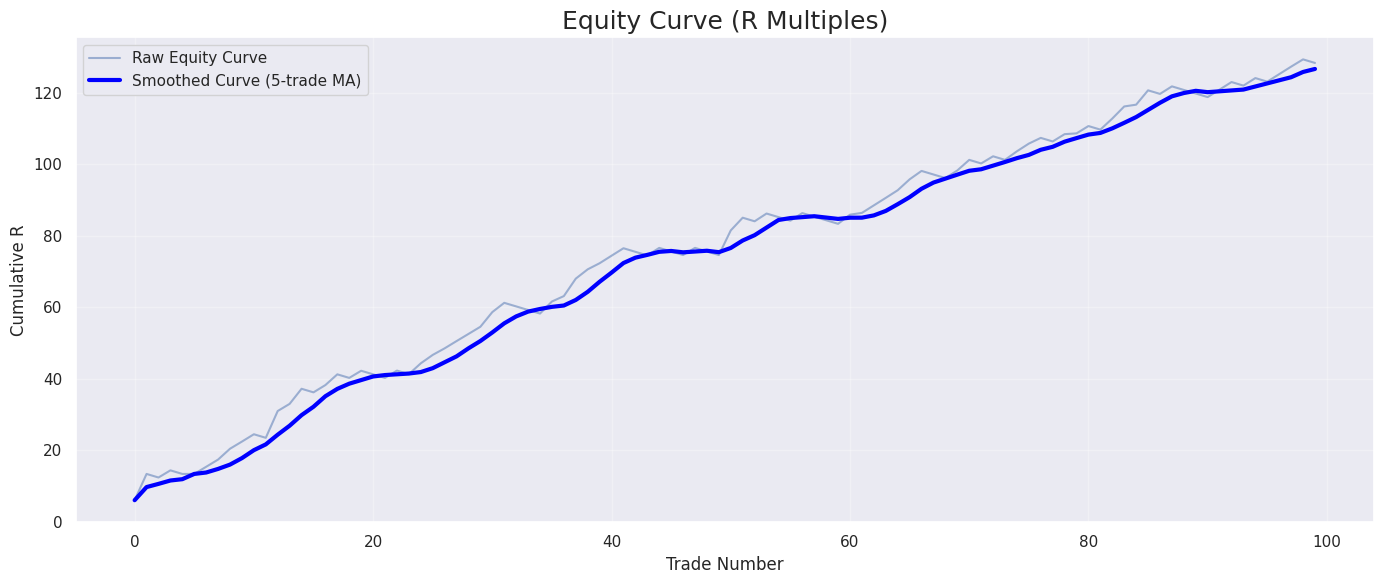

Max Drawdown (R): -3.0


In [15]:
import matplotlib.pyplot as plt

print("Trades:", len(df))
print("Win rate:", df["is_win"].mean())
print("Average R:", df["R"].mean())
print("Median R:", df["R"].median())
print("Total R:", df["R"].sum())

# --- 1. Sort trades properly by DATE and ENTRY TIME ---
df = df.sort_values(by=["DATE", "ENTRY_TIME"]).reset_index(drop=True)

# --- 2. Recompute equity curve ---
df["equity_R"] = df["R"].cumsum()

# --- 3. Optional smoothing (rolling mean) ---
df["equity_smooth"] = df["equity_R"].rolling(window=5, min_periods=1).mean()

# --- 4. Plot ---
plt.figure(figsize=(14,6))

plt.plot(df["equity_R"], label="Raw Equity Curve", linewidth=1.5, alpha=0.5)
plt.plot(df["equity_smooth"], label="Smoothed Curve (5-trade MA)", linewidth=3, color="blue")

plt.title("Equity Curve (R Multiples)", fontsize=18)
plt.xlabel("Trade Number")
plt.ylabel("Cumulative R")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- 5. Max Drawdown ---
curve = df["equity_R"]
drawdown = curve - curve.cummax()
print("Max Drawdown (R):", round(drawdown.min(), 2))



## **DISTRIBUTIONS & VISUAL EDA**

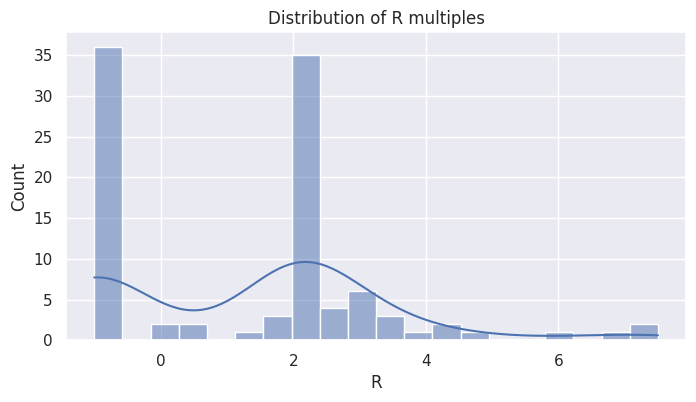

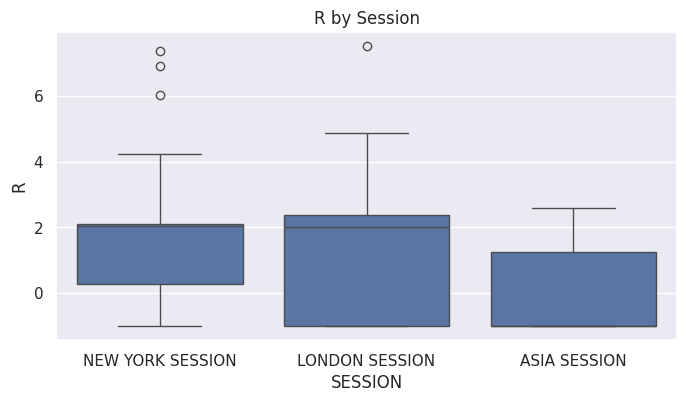

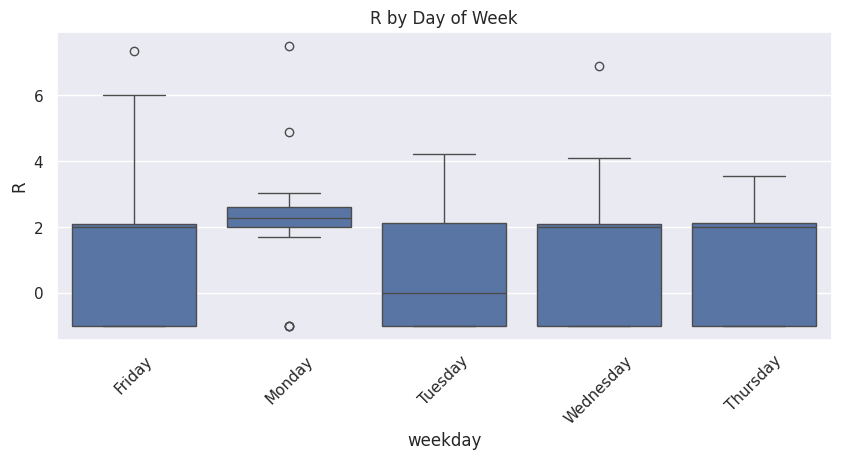

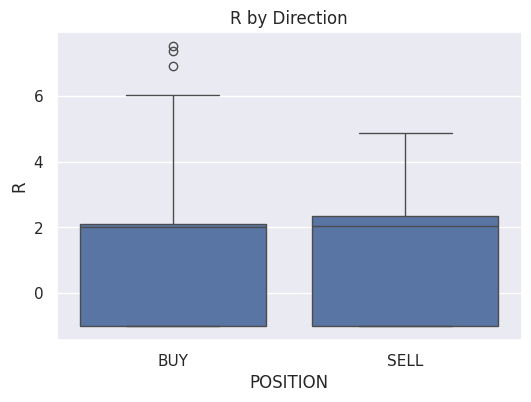

In [ ]:
# R distribution
plt.figure(figsize=(8,4))
sns.histplot(df["R"], kde=True, bins=20)
plt.title("Distribution of R multiples")
plt.show()

# Boxplots
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x="SESSION", y="R")
plt.title("R by Session")
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(data=df, x="weekday", y="R")
plt.title("R by Day of Week")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="POSITION", y="R")
plt.title("R by Direction")
plt.show()


## **GROUPED PERFORMANCE DATA**

In [ ]:
def performance_table(col):
    return (df.groupby(col)
              .agg(
                  trades=(col, "size"),
                  win_rate=("is_win", "mean"),
                  avg_R=("R", "mean"),
                  total_R=("R", "sum")
              )
            .sort_values("avg_R", ascending=False))

print("By SESSION:")
display(performance_table("SESSION"))

print("By WEEKDAY:")
display(performance_table("weekday"))

print("By POSITION:")
display(performance_table("POSITION"))


By SESSION:


,trades,win_rate,avg_R,total_R
SESSION,,,,
NEW YORK SESSION,46,0.760870,1.713261,78.81
LONDON SESSION,44,0.568182,1.134091,49.90
ASIA SESSION,10,0.300000,-0.038000,-0.38


By WEEKDAY:


,trades,win_rate,avg_R,total_R
weekday,,,,
Monday,18,0.833333,2.212778,39.83
Friday,20,0.700000,1.523500,30.47
Wednesday,24,0.625000,1.266667,30.40
Thursday,19,0.526316,0.795789,15.12
Tuesday,19,0.473684,0.658421,12.51


By POSITION:


,trades,win_rate,avg_R,total_R
POSITION,,,,
SELL,49,0.693878,1.380408,67.64
BUY,51,0.568627,1.190000,60.69


## **HYPOTHESES TESTING**

**1. Does session affect win rate? (Chi-square test)**

**Hypotheses**

- **H0 (NULL):** Win rate is independent of session.
- **H1 (ALT):** Win rate depends on session.

In [ ]:
contingency = pd.crosstab(df['SESSION'], df['is_win'])
chi2, p, dof, exp = chi2_contingency(contingency)

print("Chi-square value:", chi2)
print("p-value:", p)
if p < 0.05:
    print("Reject H0 → Session has a significant effect on win rate.")
else:
    print("Fail to reject H0 → No significant difference between sessions.")


Chi-square value: 8.772973990365294
p-value: 0.012444369651574631
Reject H0 → Session has a significant effect on win rate.


Low P-Value < 0.05. London/New York Session outperformance of Asia session is statistically real.

**2. Are sells more profitable than buys? (T-test)**

**Hypotheses:**

- **H0 (NULL):** Mean R for buys = Mean R for sells
- **H1 (ALT):** Mean R for buys ≠ Mean R for sells

In [ ]:
buys = df[df["POSITION"] == "BUY"]["R"]
sells = df[df["POSITION"] == "SELL"]["R"]

t_stat, p = ttest_ind(buys, sells, equal_var=False)

print("p-value:", p)
if p < 0.05:
    print("Reject H0 → Buys and sells have significantly different profitability.")
else:
    print("Fail to reject H0 → No significant difference.")



p-value: 0.6441270642254778
Fail to reject H0 → No significant difference.


**3. Is Monday statistically better? (Z-test)**

**Hypotheses:**

- **H0 (NULL):** Win rate Monday = Win rate other days
- **H1 (ALT):** Win rate Monday > Win rate other days

In [ ]:
monday = df[df['weekday'] == "Monday"]
others = df[df['weekday'] != "Monday"]

success = [monday['is_win'].sum(), others['is_win'].sum()]
nobs = [len(monday), len(others)]

stat, p = proportions_ztest(success, nobs, alternative='larger')
print("p-value:", p)

if p < 0.05:
    print("Reject H0 → Mondays outperform significantly.")
else:
    print("Fail to reject H0 → Monday edge may be noise.")



p-value: 0.024237512302606287
Reject H0 → Mondays outperform significantly.


**4. Does R correlate with win probability?**

**Hypotheses:**

- **H0 (NULL):** No linear correlation between planned R and outcome (win/loss)
- **H1 (ALT):** There is correlation

In [ ]:
r, p = pearsonr(df['R'], df['is_win'])
print("Correlation:", r, "p-value:", p)

if p < 0.05:
    print("Reject H0 → R multiple is significantly associated with win rate.")
else:
    print("No significant correlation between R and win probability.")



Correlation: 0.8440825499746979 p-value: 2.8325497599819383e-28
Reject H0 → R multiple is significantly associated with win rate.


**5. Do winners and losers have different durations? (T-test)**

**Hypotheses:**

- **H0 (NULL):** Mean duration winners = mean duration losers
- **H1 (ALT):** Different durations

In [ ]:
def duration_to_hours(x):
    x = str(x).strip()

    # If empty or NaN-like
    if x in ["nan", "NaT", "", None]:
        return np.nan

    # Case 1: Standard HH:MM:SS or HH:MM
    try:
        if "(" not in x:
            td = pd.to_timedelta(x)
            return td.total_seconds() / 3600
    except:
        pass

    # Case 2: "HH:MM (Next Day)"
    try:
        base = x.split("(")[0].strip()  # '14:00'
        td = pd.to_timedelta(base)
        return (td.total_seconds() + 24*3600) / 3600
    except:
        return np.nan



In [ ]:
df["duration_hours"] = df["DURATION"].apply(duration_to_hours)


In [ ]:
wins = df[df['is_win']==1]['duration_hours']
losses = df[df['is_win']==0]['duration_hours']

t, p = ttest_ind(wins, losses)

print("p-value:", p)
if p < 0.05:
    print("Reject H0 → Duration affects win likelihood.")
else:
    print("Duration does not significantly influence win/loss.")


p-value: 0.7510574878120176
Duration does not significantly influence win/loss.


**6. Do Certain Hours Perform Better?**

**Hypotheses:**

- **H0 (NULL):** All hours have equal mean R
- **H1 (ALT):** At least one hour is different

In [ ]:
df["ENTRY_TIME_parsed"] = pd.to_datetime(df["ENTRY_TIME"], format="%H:%M:%S")
df["hour"] = df["ENTRY_TIME_parsed"].dt.hour


In [ ]:
hour_groups = [group["R"].values for hour, group in df.groupby("hour")]

f, p = f_oneway(*hour_groups)
print("p-value:", p)

if p < 0.05:
    print("Reject H0 → Some hours perform significantly better or worse.")
else:
    print("No significant difference between hours.")


p-value: 0.2189467242993697
No significant difference between hours.
